In [1]:
import pandas as pd
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 500)

import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()

import pymc3 as pm
print(pm.__version__)
import theano.tensor as tt
import patsy

C:\Miniconda3\envs\ppc\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


3.4.1


# Reaction Times In A Sleep Deprivation Study
The dataset contains the average reaction time per day for subjects in a sleep deprivation study. On day 0 the subjects had their normal amount of sleep. Starting that night they were restricted to 3 hours of sleep per night. The observations represent the average reaction time on a series of tests given each day to each subject. Data from: https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/lme4/sleepstudy.csv

### Data loading

In [2]:
sleep = pd.read_csv('../datasets/sleepstudy.csv', index_col=0)
sleep['Subject'] = pd.Categorical(sleep['Subject'], ordered=False)
sleep.head(15)

Reaction  Days Subject
1   249.5600     0     308
2   258.7047     1     308
3   250.8006     2     308
4   321.4398     3     308
5   356.8519     4     308
6   414.6901     5     308
7   382.2038     6     308
8   290.1486     7     308
9   430.5853     8     308
10  466.3535     9     308
11  222.7339     0     309
12  205.2658     1     309
13  202.9778     2     309
14  204.7070     3     309
15  207.7161     4     309

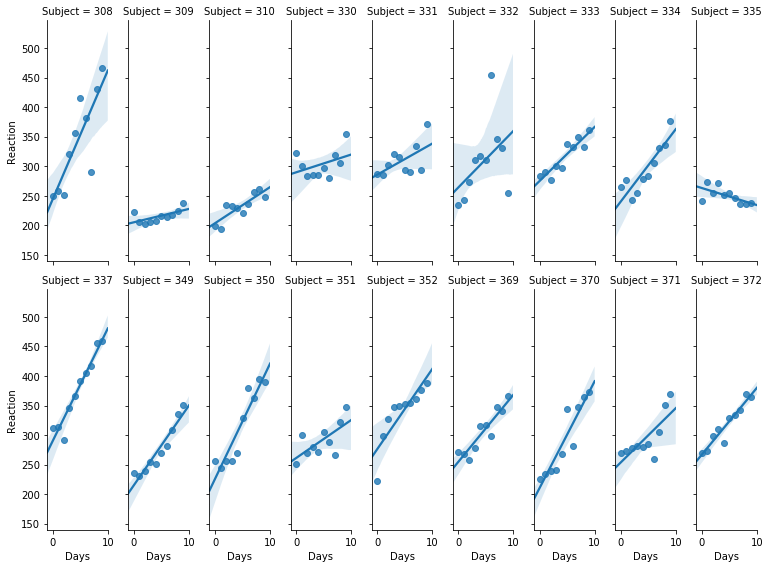

In [3]:
sns.lmplot(x="Days", y="Reaction", col="Subject", data=sleep, col_wrap=9, palette="muted", aspect=0.3, size=4)


## Model 1: Random effect on only the intercepts

Design matrix for the fixed effect

In [4]:
X = patsy.dmatrix("1 + Days", data=sleep, return_type='dataframe')
X = np.asarray(X)
X[1:10, :]

array([[1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.],
       [1., 5.],
       [1., 6.],
       [1., 7.],
       [1., 8.],
       [1., 9.]])

Design matrix for the random effect (intercept only). This means that each subject will deviate from the average intercecpt by some amount, but the slope will be the same across participants

In [5]:
Z = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z = np.asarray(Z)
Z

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [6]:
Y = np.asarray(sleep['Reaction'])
Y.mean()

298.50789166666664

In [7]:
with pm.Model() as model:

    #beta_X = pm.Normal('beta_X', mu=0, sd=100, shape=X.shape[1])
    
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=10000) # Intercept is constrained to be positive because reaction time are positive only
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X = tt.stack(beta_X_intercept, beta_X_slope)
    
    estimate_X = pm.math.dot(X, beta_X)

    # Non Centered version
    # The idea behind the non-centered version is to make sampling easier by sampling on probability distributions with the similar dimension. 
    # For example if the sampler is tune on a Normal (0, 1), it will have worse performance in sampling tiny values because the leap frog jump will be to long.
    # Hence, we sample the gamma_raw value and a scaler independently. Normal(0, 30) is the same as N(0, 1) * 30
    scaler_Z = pm.HalfNormal('scaler_Z', sd=100) # The scaler is quite wide since the intercept value can vary quite much around the average value of 300 ms.

    gamma_Z_raw = pm.Normal('gamma_Z_raw', mu=0, sd=1, shape=Z.shape[1])
    gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_raw * scaler_Z)
    
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_X + estimate_Z
    sigma = pm.HalfNormal('sigma', sd=100) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma, observed=Y)
    
    trace = pm.sample(draws=3000, chains=4, njobs=4, tune=1500, nuts_kwargs={'target_accept':0.95})

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '3376' (I am process '2236')
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, gamma_Z_raw, scaler_Z_log__, beta_X_slope, beta_X_intercept_log__]
The number of effective samples is smaller than 25% for some parameters.


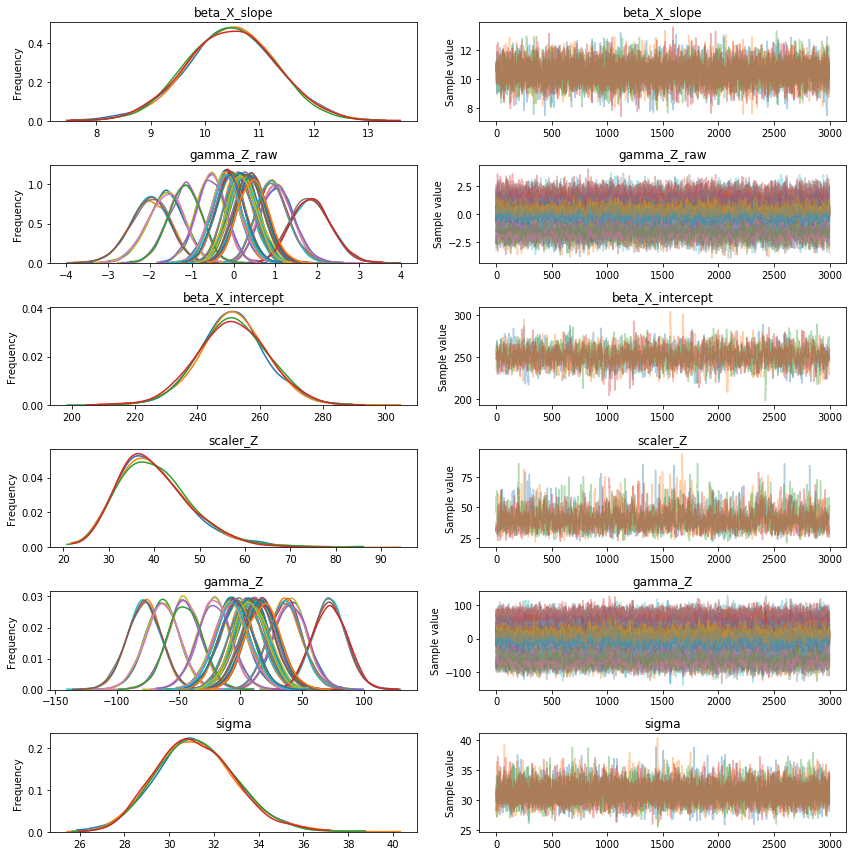

In [8]:
_ = pm.traceplot(trace)

In [9]:
pm.summary(trace)

mean         sd  mc_error     hpd_2.5    hpd_97.5  \
beta_X_slope       10.489232   0.809703  0.009080    8.978840   12.159585   
gamma_Z_raw__0      1.044966   0.394726  0.008025    0.310044    1.844181   
gamma_Z_raw__1     -2.002716   0.474126  0.009339   -2.907554   -1.052368   
gamma_Z_raw__2     -1.624926   0.438709  0.008365   -2.538372   -0.820178   
gamma_Z_raw__3      0.113959   0.342945  0.006139   -0.527309    0.804303   
gamma_Z_raw__4      0.262574   0.348597  0.006064   -0.433304    0.941951   
gamma_Z_raw__5      0.215020   0.344617  0.006128   -0.445070    0.902405   
gamma_Z_raw__6      0.422633   0.349464  0.006376   -0.292158    1.085999   
gamma_Z_raw__7     -0.075085   0.342269  0.005964   -0.737657    0.601934   
gamma_Z_raw__8     -1.167653   0.389288  0.007304   -1.935810   -0.414769   
gamma_Z_raw__9      1.853231   0.468631  0.010206    0.972076    2.777631   
gamma_Z_raw__10    -0.548122   0.353186  0.006189   -1.261682    0.145324   
gamma_Z_raw__11     0.363178   0.348371  0.006453   -0.307927    1.048594   
gamma_Z_raw__12    -0.203142   0.349834  0.006323   -0.895776    0.501401   
gamma_Z_raw__13     0.934307   0.379891  0.007567    0.206002    1.693209   
gamma_Z_raw__14     0.180189   0.343735  0.006174   -0.508111    0.854996   
gamma_Z_raw__15    -0.167137   0.345451  0.005659   -0.822563    0.533342   
gamma_Z_raw__16    -0.083988   0.345232  0.006197   -0.756091    0.601537   
gamma_Z_raw__17     0.468331   0.354065  0.006440   -0.209741    1.171861   
beta_X_intercept  251.411664  10.954472  0.243446  230.057914  272.993411   
scaler_Z           40.344161   8.282694  0.198834   25.915557   56.419976   
gamma_Z__0         40.648842  13.786429  0.247039   13.323993   67.299622   
gamma_Z__1        -78.134840  13.722092  0.244142 -105.781078  -52.384692   
gamma_Z__2        -63.375094  13.875115  0.254277  -91.035226  -36.399889   
gamma_Z__3          4.407472  13.641738  0.252648  -21.495898   31.905399   
gamma_Z__4         10.211992  13.757605  0.243001  -17.162383   37.040115   
gamma_Z__5          8.314978  13.594362  0.247234  -18.429893   34.823779   
gamma_Z__6         16.452337  13.643010  0.245558  -10.324850   42.895014   
gamma_Z__7         -2.977054  13.632083  0.250708  -29.330274   24.051400   
gamma_Z__8        -45.576386  13.698333  0.259195  -71.988482  -18.274979   
gamma_Z__9         72.197958  13.731225  0.247388   45.331811   98.432849   
gamma_Z__10       -21.410308  13.699961  0.252174  -48.856373    5.416623   
gamma_Z__11        14.094629  13.591073  0.253140  -12.601187   41.266214   
gamma_Z__12        -7.921532  13.873086  0.262009  -35.342831   19.807259   
gamma_Z__13        36.392773  13.679968  0.246019    9.278309   62.919454   
gamma_Z__14         6.963934  13.622074  0.252043  -21.054005   33.483690   
gamma_Z__15        -6.557152  13.779422  0.240141  -33.876278   19.903086   
gamma_Z__16        -3.341537  13.733717  0.257647  -29.861242   23.422559   
gamma_Z__17        18.226117  13.674433  0.241188   -7.883522   45.660459   
sigma              31.217677   1.765641  0.017427   27.805670   34.681648   

                        n_eff      Rhat  
beta_X_slope      8634.252095  1.000076  
gamma_Z_raw__0    2454.683291  1.000470  
gamma_Z_raw__1    2528.285012  0.999903  
gamma_Z_raw__2    2560.770147  0.999908  
gamma_Z_raw__3    2907.050514  1.000254  
gamma_Z_raw__4    2976.639855  1.000026  
gamma_Z_raw__5    2867.059752  1.000038  
gamma_Z_raw__6    2686.426258  0.999976  
gamma_Z_raw__7    2968.715564  1.000147  
gamma_Z_raw__8    2681.416606  0.999927  
gamma_Z_raw__9    2120.822325  1.000502  
gamma_Z_raw__10   2889.695117  1.000136  
gamma_Z_raw__11   2756.387077  0.999976  
gamma_Z_raw__12   2989.548755  1.000115  
gamma_Z_raw__13   2433.944466  1.000325  
gamma_Z_raw__14   2846.550896  1.000030  
gamma_Z_raw__15   3084.301567  1.000080  
gamma_Z_raw__16   2866.457197  0.999955  
gamma_Z_raw__17   2739.759071  1.000345  
beta_X_intercept  1877.630

In [10]:
#pm.plot_posterior(trace);

## Posterior predictive check

In [11]:
trace_df = pm.trace_to_dataframe(trace)

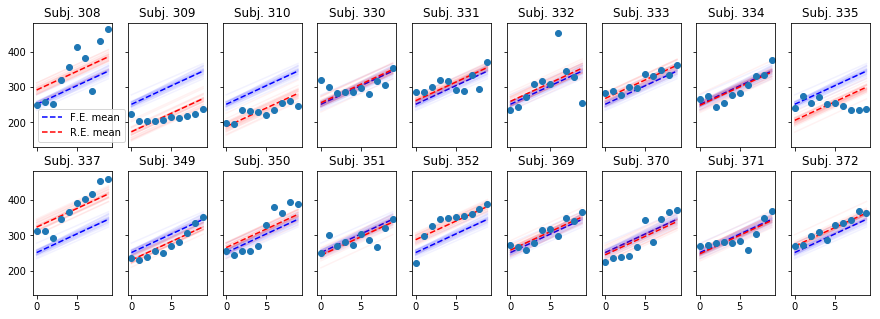

In [12]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500]):
        ax[i].plot(days, b0 + days*b1, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0 in trace_df['gamma_Z__{}'.format(i)][::500]:
        ax[i].plot(days, trace_df['beta_X_intercept'].mean() + b0 + 
                   days * trace_df['beta_X_slope'].mean(), '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + trace_df['gamma_Z__{}'.format(i)].mean() + 
               days * trace_df['beta_X_slope'].mean(), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend()

## Random effect on the intercepts and slopes
Note: It may be beneficial to center and standardize the data

Design matrix for the fixed effect

In [4]:
X = patsy.dmatrix("1 + Days", data=sleep, return_type='dataframe')
X = np.asarray(X)
X[1:15, :]

array([[1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.],
       [1., 5.],
       [1., 6.],
       [1., 7.],
       [1., 8.],
       [1., 9.],
       [1., 0.],
       [1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.]])

Design matrix for the random effects. Intercept and slope are modelled separately to have more control on the prior

In [5]:
# Random effect on the intercepts and slopes
Z_intercept = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z_intercept = np.asarray(Z_intercept)

Z_slope = patsy.dmatrix('0 + Subject:Days', data=sleep, return_type='dataframe')
Z_slope = np.asarray(Z_slope)

Z = np.concatenate((Z_intercept, Z_slope), axis=1)

print('Z_intercept has shape ({}, {})'.format(*Z_intercept.shape))
print('Z_slope has shape ({}, {})'.format(*Z_slope.shape))
print('Z has shape ({}, {})'.format(*Z.shape))

Z_intercept has shape (180, 18)
Z_slope has shape (180, 18)
Z has shape (180, 36)


In [6]:
Z_intercept

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [7]:
Z_slope

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 7.],
       [0., 0., 0., ..., 0., 0., 8.],
       [0., 0., 0., ..., 0., 0., 9.]])

In [8]:
Z

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 7.],
       [0., 0., 0., ..., 0., 0., 8.],
       [0., 0., 0., ..., 0., 0., 9.]])

In [9]:
Y = np.asarray(sleep['Reaction'])

In [10]:
with pm.Model() as model:
   
    ## Fixed effect
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=10000) # contrain it to positive values
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X = tt.stack(beta_X_intercept, beta_X_slope)
    
    estimate_X = pm.math.dot(X, beta_X)
    
    ## Random effect
    # Non Centered version
    scaler_intercept = pm.HalfNormal('scaler_intercept', sd=100)
    gamma_Z_intercept_raw = pm.Normal('gamma_Z_intercept_raw', mu=0, sd=1, shape=Z_intercept.shape[1])
    gamma_Z_intercept = pm.Deterministic('gamma_Z_intercept', gamma_Z_intercept_raw * scaler_intercept)

    scaler_slope = pm.HalfNormal('scaler_slope', sd=100)
    gamma_Z_slope_raw = pm.Normal('gamma_Z_slope_raw', mu=0, sd=1, shape=Z_slope.shape[1])
    gamma_Z_slope = pm.Deterministic('gamma_Z_slope', gamma_Z_slope_raw * scaler_slope)
    
    estimate_Z = pm.math.dot(Z_intercept, gamma_Z_intercept) + pm.math.dot(Z_slope, gamma_Z_slope) 
    
    ## likelihood
    mu_estimate = pm.Deterministic('mu_estimate', estimate_X + estimate_Z)
    sigma_unexplained = pm.HalfNormal('sigma_unexplained', sd=1000) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=mu_estimate, sd=sigma_unexplained, observed=Y)
    
    trace = pm.sample(draws=3000, chains=4, njobs=4, tune=1500, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_unexplained_log__, gamma_Z_slope_raw, scaler_slope_log__, gamma_Z_intercept_raw, scaler_intercept_log__, beta_X_slope, beta_X_intercept_log__]


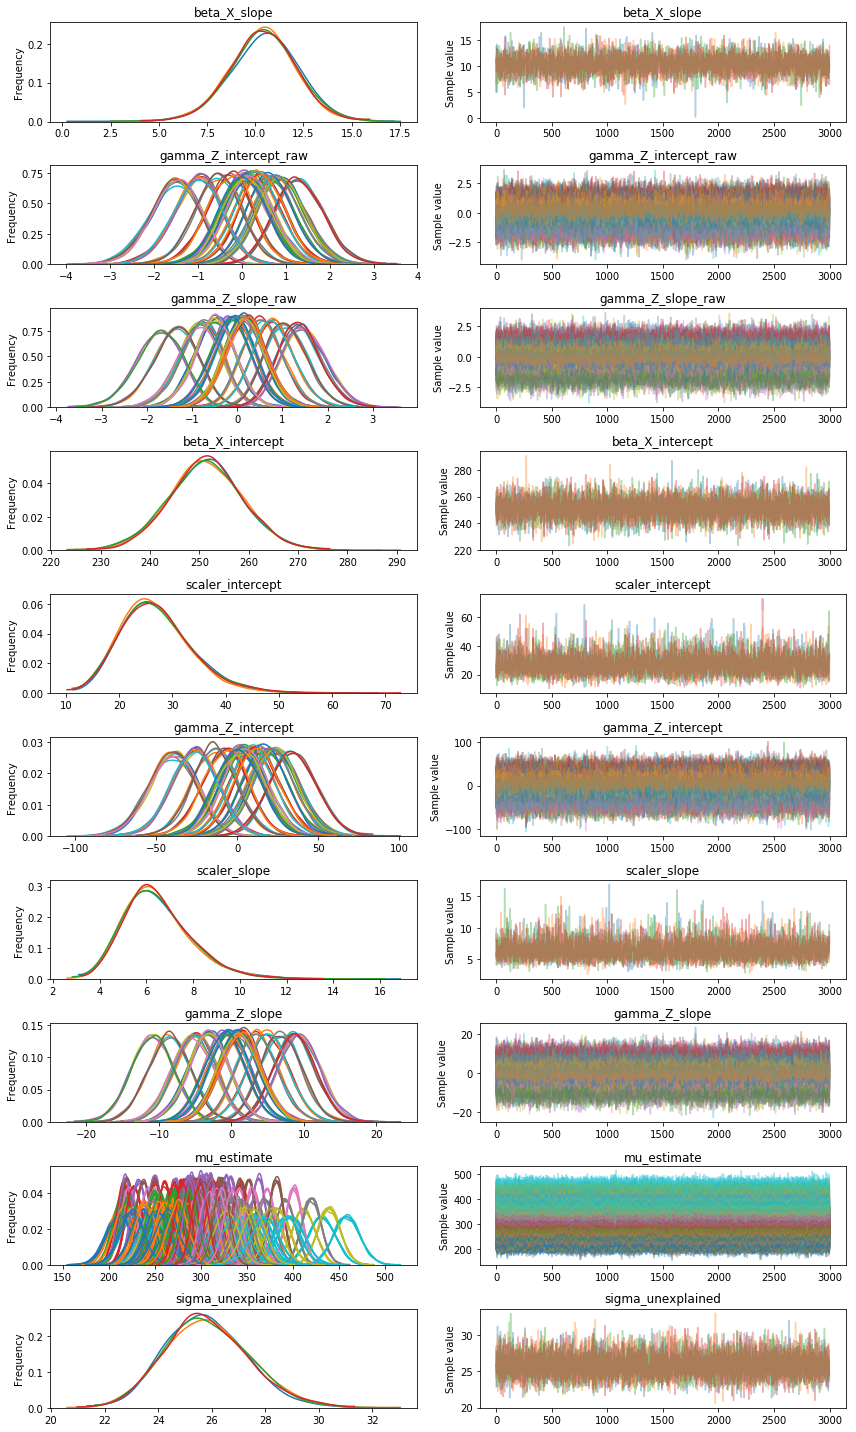

In [11]:
_ = pm.traceplot(trace)

In [12]:
pm.summary(trace)

mean         sd  mc_error     hpd_2.5  \
beta_X_slope                10.426796   1.708197  0.026220    7.157592   
gamma_Z_intercept_raw__0     0.056344   0.533567  0.005075   -1.011583   
gamma_Z_intercept_raw__1    -1.537266   0.570920  0.005386   -2.623176   
gamma_Z_intercept_raw__2    -1.490486   0.562650  0.005128   -2.616054   
gamma_Z_intercept_raw__3     0.938742   0.548371  0.005074   -0.092427   
gamma_Z_intercept_raw__4     0.882445   0.540489  0.005630   -0.178845   
gamma_Z_intercept_raw__5     0.355268   0.534552  0.004735   -0.680225   
gamma_Z_intercept_raw__6     0.657065   0.534994  0.005343   -0.345854   
gamma_Z_intercept_raw__7    -0.282289   0.534354  0.004311   -1.344655   
gamma_Z_intercept_raw__8     0.031952   0.552665  0.005198   -1.052919   
gamma_Z_intercept_raw__9     1.321795   0.553331  0.004965    0.226318   
gamma_Z_intercept_raw__10   -0.987468   0.548838  0.004861   -2.067634   
gamma_Z_intercept_raw__11   -0.542168   0.536652  0.004580   -1.540776   
gamma_Z_intercept_raw__12    0.196485   0.533010  0.004565   -0.868956   
gamma_Z_intercept_raw__13    0.795433   0.539948  0.005170   -0.257966   
gamma_Z_intercept_raw__14    0.129567   0.531146  0.004605   -0.869560   
gamma_Z_intercept_raw__15   -1.015789   0.548762  0.004626   -2.157918   
gamma_Z_intercept_raw__16    0.036161   0.531966  0.005059   -1.020893   
gamma_Z_intercept_raw__17    0.474265   0.527465  0.005499   -0.623334   
gamma_Z_slope_raw__0         1.489377   0.490144  0.005453    0.574895   
gamma_Z_slope_raw__1        -1.363243   0.499487  0.005155   -2.394573   
gamma_Z_slope_raw__2        -0.849750   0.476062  0.004747   -1.769351   
gamma_Z_slope_raw__3        -0.788198   0.464508  0.004981   -1.674975   
gamma_Z_slope_raw__4        -0.506418   0.453390  0.005222   -1.397374   
gamma_Z_slope_raw__5        -0.050894   0.452238  0.005006   -0.960697   
gamma_Z_slope_raw__6        -0.041781   0.443844  0.005007   -0.959573   
gamma_Z_slope_raw__7         0.178564   0.449432  0.004919   -0.674758   
gamma_Z_slope_raw__8        -1.732877   0.516279  0.005248   -2.719033   
gamma_Z_slope_raw__9         1.378430   0.483858  0.005375    0.447460   
gamma_Z_slope_raw__10        0.216776   0.451848  0.004255   -0.655020   
...                               ...        ...       ...         ...   
mu_estimate__151           240.232717  11.248460  0.088627  218.127935   
mu_estimate__152           255.716094   9.664979  0.076764  236.683781   
mu_estimate__153           271.199471   8.519520  0.068543  254.375983   
mu_estimate__154           286.682848   8.002440  0.065354  270.551173   
mu_estimate__155           302.166225   8.233000  0.067911  285.898095   
mu_estimate__156           317.649602   9.154887  0.075632  299.663872   
mu_estimate__157           333.132979  10.589053  0.087155  311.334685   
mu_estimate__158           348.616356  12.358420  0.101190  324.365766   
mu_estimate__159           364.099733  14.339438  0.116835  334.909420   
mu_estimate__160           252.350401  12.641453  0.096860  227.486725   
mu_estimate__161           261.785602  10.854889  0.084812  240.317283   
mu_estimate__162           271.220803   9.348459  0.074903  252.925310   
mu_estimate__163           280.656005   8.276565  0.068075  264.552441   
mu_estimate__164           290.091206   7.819984  0.065300  275.035895   
mu_estimate__165           299.526407   8.083659  0.067085  284.257263   
mu_estimate__166           308.961608   9.004539  0.073094  291.626917   
mu_estimate__167           318.396809  10.409643  0.082410  298.759917   
mu_estimate__168           327.832011  12.131875  0.094055  303.935073   
mu_estimate__169           337.267212  14.055138  0.107274  308.461723   
mu_estimate__170           263.880865  12.604758  0.100050  238.801780   
mu_estimate__171           275.620338  10.829888  0.083568  253.898345   
mu_estimate__172           287.359811   9.339475  0.070004  268.734292   
mu_estimate__173           299.099285

In [13]:
#pm.plot_posterior(trace);

In [14]:
trace_df = pm.trace_to_dataframe(trace)
trace_df.head().T

0           1           2           3  \
beta_X_slope                10.744845   11.209633   10.514406   12.383398   
gamma_Z_intercept_raw__0    -0.421835    0.443396   -0.045621    0.039152   
gamma_Z_intercept_raw__1    -1.409448   -1.894118   -1.822506   -0.636021   
gamma_Z_intercept_raw__2    -1.290186   -2.013256   -1.027181   -0.786692   
gamma_Z_intercept_raw__3     0.624851    1.242075    0.773827    0.968174   
gamma_Z_intercept_raw__4    -0.548000    2.237522    0.489037    1.381103   
gamma_Z_intercept_raw__5     1.004265   -0.518878    0.461159    0.096857   
gamma_Z_intercept_raw__6     1.219595    0.300569    1.034189    0.748499   
gamma_Z_intercept_raw__7    -0.375807   -0.270906   -0.400401    0.457612   
gamma_Z_intercept_raw__8     0.560239   -0.138323   -0.069788    0.427536   
gamma_Z_intercept_raw__9     0.812362    1.593908    0.906898    0.921748   
gamma_Z_intercept_raw__10    0.123795   -2.049749   -0.589819   -0.885989   
gamma_Z_intercept_raw__11   -1.267172    0.045121   -1.050738   -0.289027   
gamma_Z_intercept_raw__12   -0.544003    0.851681   -0.180020    0.188777   
gamma_Z_intercept_raw__13    0.552497    0.807098    0.841070    0.882016   
gamma_Z_intercept_raw__14   -0.085165    0.400900    0.161135    0.447188   
gamma_Z_intercept_raw__15   -1.397336   -0.546935   -0.808308   -0.721236   
gamma_Z_intercept_raw__16    0.552410   -0.718437   -0.013230    0.557512   
gamma_Z_intercept_raw__17    1.541343   -0.736269    0.941700    0.369419   
gamma_Z_slope_raw__0         1.197053    1.138997    1.465621    1.153860   
gamma_Z_slope_raw__1        -0.817200   -1.510026   -1.671898   -1.849507   
gamma_Z_slope_raw__2        -0.676720   -0.775055   -1.409203   -0.997840   
gamma_Z_slope_raw__3        -0.322246   -1.195091   -1.022801   -1.358081   
gamma_Z_slope_raw__4         0.314275   -1.490883   -0.052400   -1.299794   
gamma_Z_slope_raw__5        -0.159988    0.316489   -0.439962   -0.013811   
gamma_Z_slope_raw__6        -0.335137    0.364148   -0.296445   -0.180596   
gamma_Z_slope_raw__7        -0.060138    0.395643    0.414927   -0.360216   
gamma_Z_slope_raw__8        -1.498307   -1.371814   -2.019737   -2.089024   
gamma_Z_slope_raw__9         1.386912    0.656399    1.514113    0.610364   
gamma_Z_slope_raw__10       -0.239560    0.930446   -0.462731    0.496648   
...                               ...         ...         ...         ...   
mu_estimate__151           235.823902  252.922879  246.861595  226.046276   
mu_estimate__152           250.271580  268.301296  262.341985  246.860636   
mu_estimate__153           264.719259  283.679713  277.822374  267.674995   
mu_estimate__154           279.166938  299.058130  293.302763  288.489355   
mu_estimate__155           293.614617  314.436547  308.783153  309.303714   
mu_estimate__156           308.062296  329.814964  324.263542  330.118074   
mu_estimate__157           322.509975  345.193381  339.743931  350.932433   
mu_estimate__158           336.957654  360.571798  355.224320  371.746793   
mu_estimate__159           351.405333  375.950215  370.704710  392.561152   
mu_estimate__160           262.462973  233.181802  254.544790  263.523484   
mu_estimate__161           269.304137  246.677245  263.509304  270.329429   
mu_estimate__162           276.145301  260.172688  272.473819  277.135373   
mu_estimate__163           282.986465  273.668131  281.438333  283.941317   
mu_estimate__164           289.827629  287.163575  290.402847  290.747262   
mu_estimate__165           296.668793  300.659018  299.367362  297.553206   
mu_estimate__166           303.509957  314.154461  308.331876  304.359151   
mu_estimate__167           310.351121  327.649905  317.296390  311.165095   
mu_estimate__168           317.192284  341.145348  326.260905  317.971039   
mu_estimate__169           324.033448  354.640791  335.225419  324.776984   
mu_estimate__170           283.302633  232.728196  282.365463  254.949283   
mu_estimate__171           291.5

In [15]:
yvars = [col for col in trace_df.columns if 'gamma_Z_slope' in col and 'raw' not in col]
xvars = [col for col in trace_df.columns if 'gamma_Z_intercept' in col and 'raw' not in col]

xvars

['gamma_Z_intercept__0',
 'gamma_Z_intercept__1',
 'gamma_Z_intercept__2',
 'gamma_Z_intercept__3',
 'gamma_Z_intercept__4',
 'gamma_Z_intercept__5',
 'gamma_Z_intercept__6',
 'gamma_Z_intercept__7',
 'gamma_Z_intercept__8',
 'gamma_Z_intercept__9',
 'gamma_Z_intercept__10',
 'gamma_Z_intercept__11',
 'gamma_Z_intercept__12',
 'gamma_Z_intercept__13',
 'gamma_Z_intercept__14',
 'gamma_Z_intercept__15',
 'gamma_Z_intercept__16',
 'gamma_Z_intercept__17']

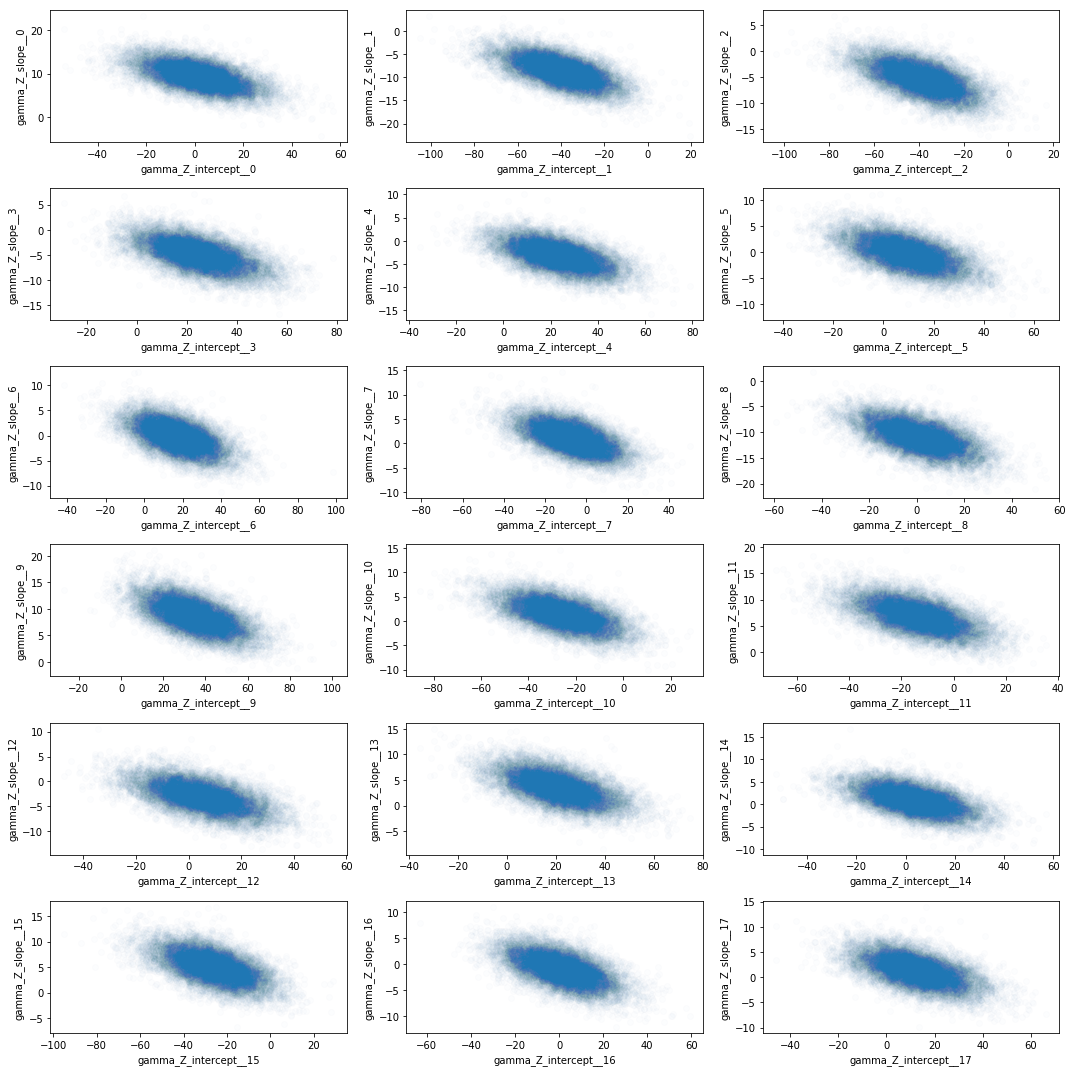

In [16]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(15, 15))
for i, axi in enumerate(ax.ravel()):
    axi.plot(trace_df[xvars[i]], trace_df[yvars[i]], 'o', alpha=0.01)
    axi.set_xlabel(xvars[i])
    axi.set_ylabel(yvars[i])
    
plt.tight_layout()

## Posterior predictive check

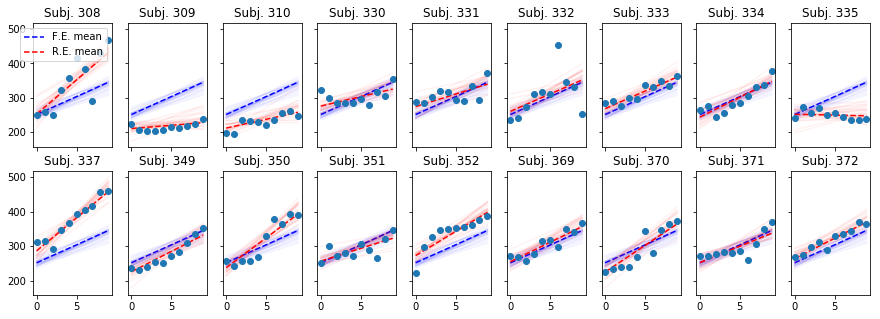

In [17]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500]):
        ax[i].plot(days, b0 + days*b1, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['gamma_Z_intercept__{}'.format(i)][::500], 
                      trace_df['gamma_Z_slope__{}'.format(i)][::500]):
        ax[i].plot(days, trace_df['beta_X_intercept'].mean() + b0 + 
                   days * (trace_df['beta_X_slope'].mean() + b1), '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + trace_df['gamma_Z_intercept__{}'.format(i)].mean() + 
               days * (trace_df['beta_X_slope'].mean() + trace_df['gamma_Z_slope__{}'.format(i)].mean()), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend()

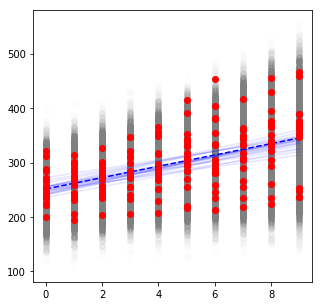

In [18]:
# Posterior distribution
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

n_draws = 25
for idx, reaction, day in zip(sleep.index-1, sleep.Reaction, sleep.Days):
    for mu, sigma in zip(trace_df['mu_estimate__{}'.format(idx)][1000::500], trace_df['sigma_unexplained'][1000::500]):
        ax.plot(np.repeat(day, n_draws), np.random.normal(loc=mu, scale=sigma, size=n_draws),
                'o',color=(0.5, 0.5, 0.5), alpha=0.01)
    
for b0, b1 in zip(trace_df['beta_X_intercept'][1000::500], trace_df['beta_X_slope'][1000::500]):
    ax.plot(np.unique(sleep.Days), b0 + np.unique(sleep.Days)*b1, '-b', alpha=0.1)

ax.plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b')

for idx, reaction, day in zip(sleep.index-1, sleep.Reaction, sleep.Days):
    ax.plot(day, reaction, 'ro', alpha=1)


In [19]:
ppc = pm.sample_ppc(trace, samples=250, model=model)

100%|█████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 919.05it/s]


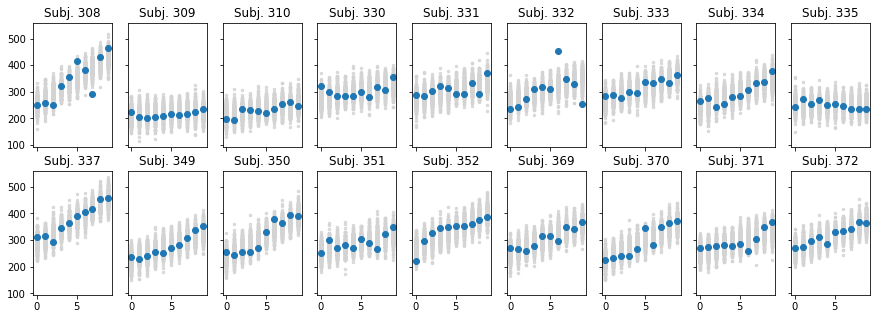

In [20]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, ppc['y_likelihood'].T[sleep.Subject==subject], marker='.', markersize=5, linestyle='none', alpha=0.8, color='lightgray')
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    ax[i].set_title('Subj. {}'.format(subject))


## Model 3: Correlation among random effects
Multivariate and cholesky
see: https://docs.pymc.io/notebooks/LKJ.html

In [331]:
n_random_effects = X.shape[1] #nu = 2
n_subjects = Z_intercept.shape[1] # J = 18

with pm.Model() as model:

    ## Fixed effect
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=10000) # contrain it to positive values
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X = tt.stack(beta_X_intercept, beta_X_slope)
    
    estimate_X = pm.math.dot(X, beta_X)
        
    ## Random effect
    # Prior on the standard deviation of the random effects
    sigma_Z = pm.HalfCauchy.dist(beta=2, shape=n_random_effects)
    
    # Build the covariance matrix
    chol_packed = pm.LKJCholeskyCov('chol_packed', n=n_random_effects, eta=1, sd_dist=sigma_Z)
    chol = pm.expand_packed_triangular(n_random_effects, chol_packed)
    
    covariance_matrix = pm.Deterministic('covariance_matrix', tt.dot(chol, chol.T))
    standard_deviations = pm.Deterministic('standard_deviations', tt.sqrt(tt.diag(covariance_matrix)))
       
    # independent component for each subject and each random effect
    gamma_Z_raw = pm.MvNormal('gamma_Z_raw', mu=np.zeros(n_random_effects), chol=chol, shape=(n_subjects, n_random_effects))
    #tt.printing.Print('gamma_Z_raw')(gamma_Z_raw.shape)
    
    # Compute the correlated random variables via the covariance matrix
    gamma_Z = tt.dot(chol, gamma_Z_raw.T)
    #tt.printing.Print('gamma_Z')(gamma_Z.shape)
    
    # Separate the coefficients for intercept and slope
    gamma_Z_intercept = pm.Deterministic('gamma_Z_intercept', gamma_Z[0, :])
    gamma_Z_slope = pm.Deterministic('gamma_Z_slope', gamma_Z[1, :])
    
    estimate_Z = pm.math.dot(Z_intercept, gamma_Z_intercept) + pm.math.dot(Z_slope, gamma_Z_slope) 

    ## likelihood
    mu_estimate = estimate_X + estimate_Z
    sigma_unexplained = pm.HalfNormal('sigma_unexplained', sd=1000) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=mu_estimate, sd=sigma_unexplained, observed=Y)
    
    trace = pm.sample(draws=3000, chains=4, njobs=4, tune=1500, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_unexplained_log__, gamma_Z_raw, chol_packed_cholesky_cov_packed__, beta_X_slope, beta_X_intercept_log__]
The number of effective samples is smaller than 10% for some parameters.


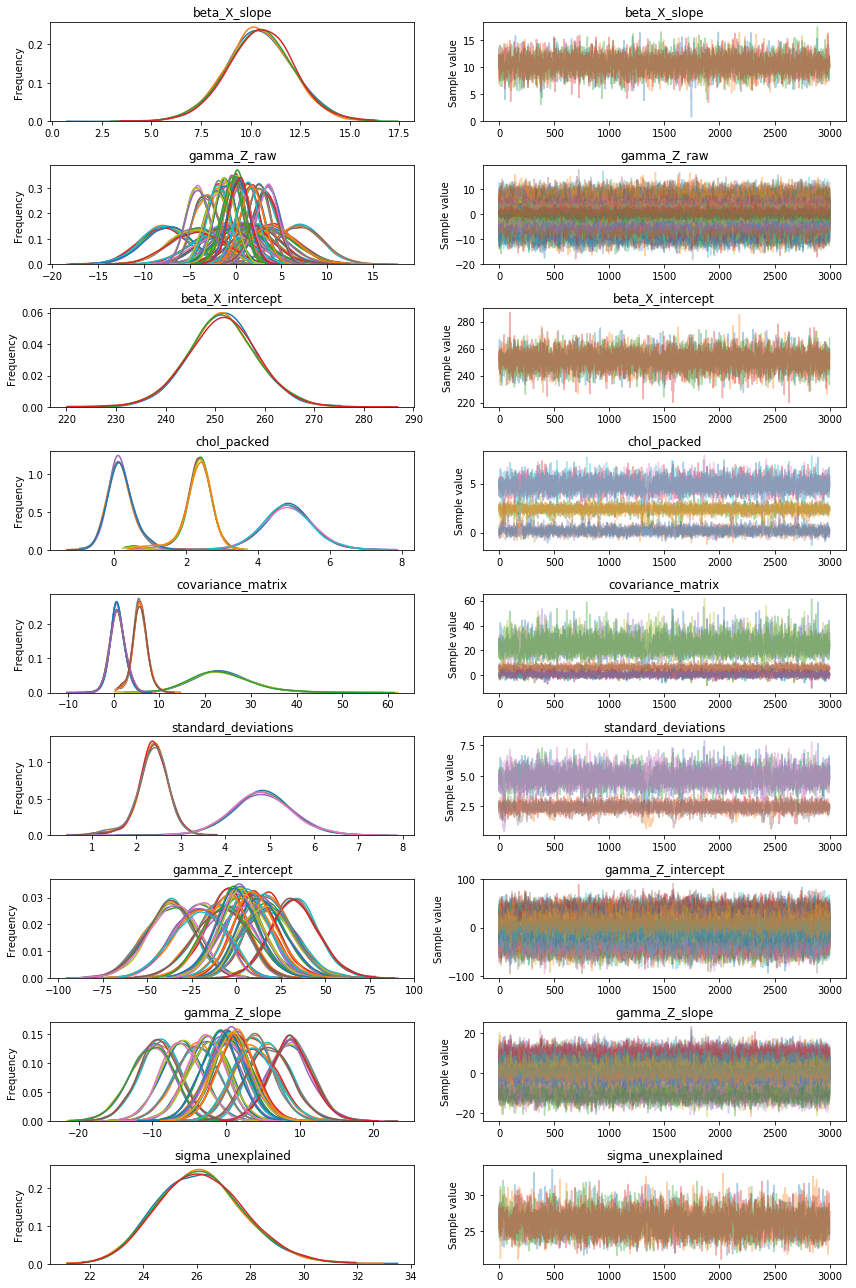

In [332]:
_ = pm.traceplot(trace)

In [370]:
covariance_matrix = np.mean(trace['covariance_matrix'], 0)
covariance_matrix

array([[23.80857639,  0.82210749],
       [ 0.82210749,  5.75487079]])

In [368]:
import scipy.sparse

In [374]:
# check code from https://blogs.sas.com/content/iml/2010/12/10/converting-between-correlation-and-covariance-matrices.html
#/** convert covariance matrix to correlation matrix **/
S = covariance_matrix
print(S)
#/** standard deviations of each variable **/
D = np.sqrt(scipy.sparse.diags(np.diag(S)).todense())
DInv = np.linalg.inv(D)
R = DInv * S * DInv #/** correlation matrix **/
print(R)

# for checking, compute pearson coefficient
print(S[0, 1]/np.prod(np.sqrt(np.diag(S))))


[[23.80857639  0.82210749]
 [ 0.82210749  5.75487079]]
[[1.         0.07023347]
 [0.07023347 1.        ]]
0.07023346610011323


In [372]:
# check code from https://blogs.sas.com/content/iml/2010/12/10/converting-between-correlation-and-covariance-matrices.html
#/** convert covariance matrix to correlation matrix **/
S = np.array([
        [1.0, 1., 8.1],
        [1.0, 16.0, 18.0],
        [8.1,18.0,81.0]
]);
 
#/** standard deviations of each variable **/
D = np.sqrt(scipy.sparse.diags(np.diag(S)).todense())
DInv = np.linalg.inv(D)
R = DInv * S * DInv #/** correlation matrix **/
print(R)

#Should be
#
#[[1.   0.25 0.9 ]
# [0.25 1.   0.5 ]
# [0.9  0.5  1.  ]]
#

[[1.   0.25 0.9 ]
 [0.25 1.   0.5 ]
 [0.9  0.5  1.  ]]


array([[ 1. ,  1. ,  8.1],
       [ 1. , 16. , 18. ],
       [ 8.1, 18. , 81. ]])

In [350]:
trace_df = pm.trace_to_dataframe(trace)

In [351]:
np.corrcoef(trace_df['gamma_Z_intercept__0'], trace_df['gamma_Z_slope__0'])

array([[ 1.        , -0.57359003],
       [-0.57359003,  1.        ]])

In [352]:
np.cov(trace_df['gamma_Z_intercept__0'], trace_df['gamma_Z_slope__0'])

array([[186.07036002, -22.3683369 ],
       [-22.3683369 ,   8.17310353]])

In [353]:
yvars = [col for col in trace_df.columns if 'gamma_Z_slope' in col and 'raw' not in col]
xvars = [col for col in trace_df.columns if 'gamma_Z_intercept' in col and 'raw' not in col]

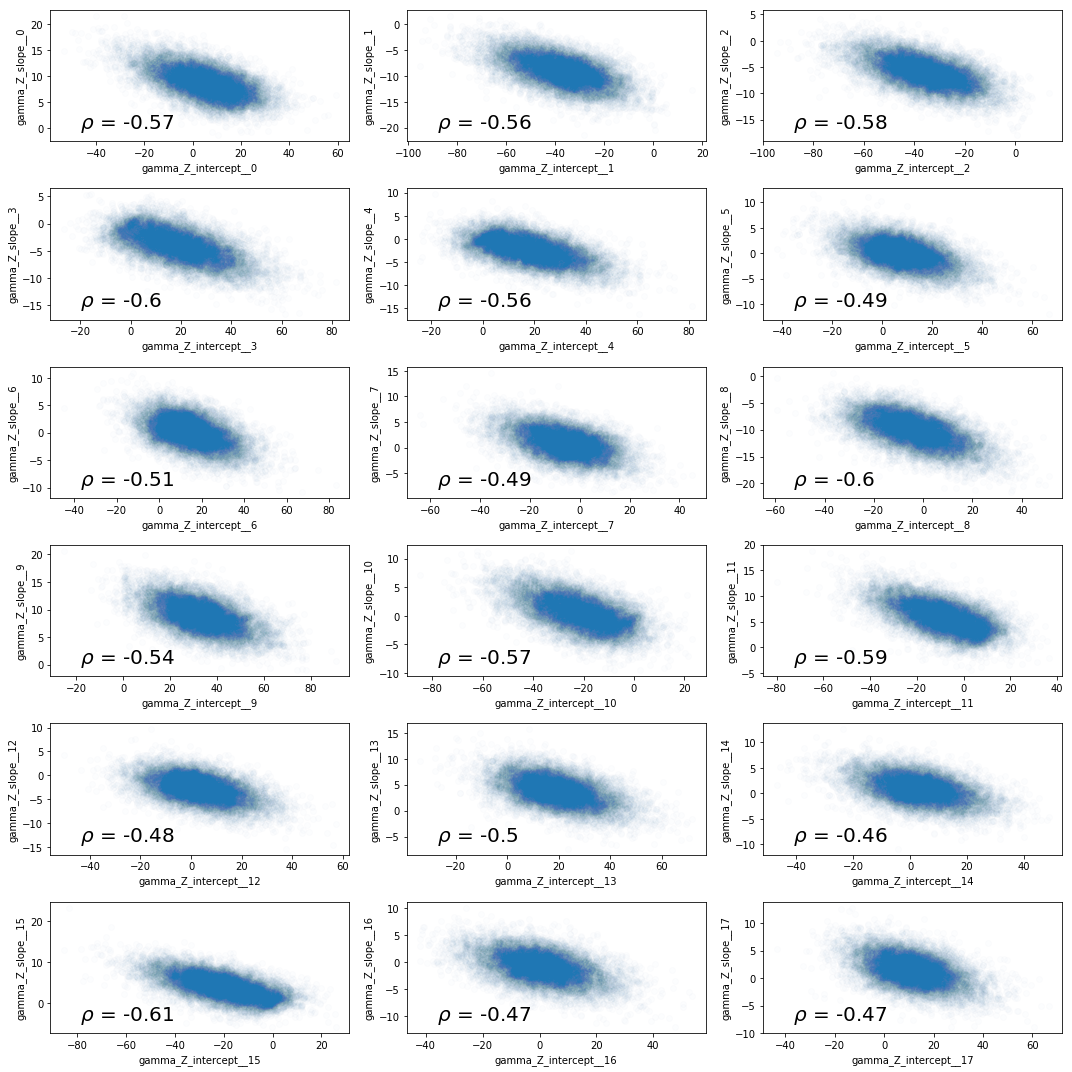

In [359]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(15, 15))
for i, axi in enumerate(ax.ravel()):
    axi.plot(trace_df[xvars[i]], trace_df[yvars[i]], 'o', alpha=0.01)
    axi.set_xlabel(xvars[i])
    axi.set_ylabel(yvars[i])
    axi.text(0.1, 0.1, '$\\rho$ = {}'.format(np.round(np.corrcoef(trace_df[xvars[i]], trace_df[yvars[i]])[0, 1], 2)),
             fontsize=20, transform=axi.transAxes)
    
plt.tight_layout()

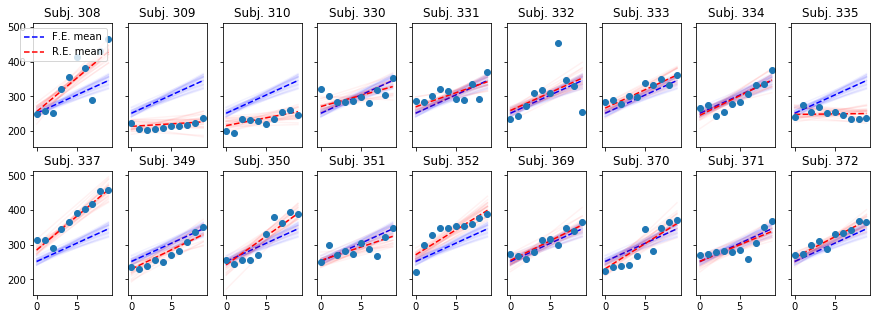

In [355]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500]):
        ax[i].plot(days, b0 + days*b1, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['gamma_Z_intercept__{}'.format(i)][::500], 
                      trace_df['gamma_Z_slope__{}'.format(i)][::500]):
        ax[i].plot(days, trace_df['beta_X_intercept'].mean() + b0 + 
                   days * (trace_df['beta_X_slope'].mean() + b1), '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + trace_df['gamma_Z_intercept__{}'.format(i)].mean() + 
               days * (trace_df['beta_X_slope'].mean() + trace_df['gamma_Z_slope__{}'.format(i)].mean()), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend()

In [356]:
ppc = pm.sample_ppc(trace, samples=250, model=model)

100%|████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 1611.77it/s]


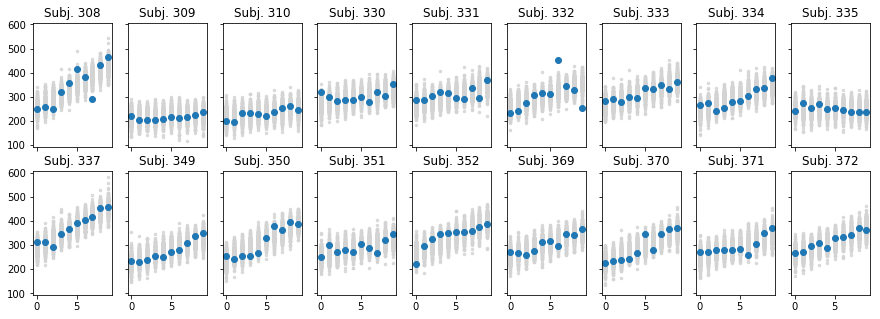

In [357]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, ppc['y_likelihood'].T[sleep.Subject==subject], marker='.', markersize=5, linestyle='none', alpha=0.8, color='lightgray')
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    ax[i].set_title('Subj. {}'.format(subject))


In [358]:
trace_df = pm.trace_to_dataframe(trace)
trace_df.head().T

0          1          2          3          4
beta_X_slope           11.218299   9.470893  12.427322  13.608659   9.544714
gamma_Z_raw__0_0        2.508731   0.705617   3.407799   3.319165   1.070036
gamma_Z_raw__0_1        2.645256   4.239637   1.095510   1.183220   3.602130
gamma_Z_raw__1_0       -7.373793  -9.966050  -7.205731 -10.569696  -9.260603
gamma_Z_raw__1_1       -3.025816  -0.956000  -5.081603  -3.494170  -3.369156
gamma_Z_raw__2_0       -9.829546  -4.278264  -9.629706  -9.547683  -6.965728
gamma_Z_raw__2_1       -1.979505  -2.437005  -1.093269  -1.655085  -2.642672
gamma_Z_raw__3_0        1.190388   5.989158  -0.987586   6.291378   1.223588
gamma_Z_raw__3_1       -0.447327  -2.717546  -1.106692  -4.963805  -1.070440
gamma_Z_raw__4_0        2.018229   8.149888  -1.919015   3.910603  -1.460991
gamma_Z_raw__4_1       -0.736646  -1.349118  -0.997672  -4.344920  -0.475618
gamma_Z_raw__5_0        3.347454   1.843194   1.216308  -0.982845  -0.834651
gamma_Z_raw__5_1       -1.700773   0.434140  -0.877855  -0.149246  -0.632905
gamma_Z_raw__6_0        1.256219   6.105592  -0.027776  -0.541336   1.169110
gamma_Z_raw__6_1       -0.707661   0.543852  -1.256569  -1.304805  -0.808520
gamma_Z_raw__7_0        0.505098  -1.852553  -2.729912  -0.350454  -2.265402
gamma_Z_raw__7_1       -0.888305   1.491149  -0.542585  -2.280481  -0.703984
gamma_Z_raw__8_0        3.652013  -4.703143  -0.094891  -4.149119  -0.182023
gamma_Z_raw__8_1       -4.973413  -2.011237  -6.144167  -3.907011  -5.022255
gamma_Z_raw__9_0       12.513731   4.156993   8.896375   1.936001  10.576979
gamma_Z_raw__9_1        0.059555   4.668959  -0.705233   3.169257   1.856374
gamma_Z_raw__10_0      -5.496797  -2.354933  -5.078856  -5.076431  -5.371183
gamma_Z_raw__10_1       0.950472   1.398123  -0.760247  -0.833847   0.292521
gamma_Z_raw__11_0      -0.536032  -2.947755   1.531398   1.098971  -2.834340
gamma_Z_raw__11_1       1.305821   2.963309   1.183261   0.963044   2.428732
gamma_Z_raw__12_0      -0.476107   1.880642   0.279292   3.024603  -1.713183
gamma_Z_raw__12_1      -0.635648  -0.923955  -0.624719  -2.840550   0.743882
gamma_Z_raw__13_0       5.285616   2.830376   4.467950   1.718372   4.948124
gamma_Z_raw__13_1       1.446939   1.845265  -0.235059   1.081409   1.487721
gamma_Z_raw__14_0      -1.046685   2.838644  -0.951882  -1.906752  -0.320007
...                          ...        ...        ...        ...        ...
gamma_Z_intercept__7    2.262855  -6.937200 -14.927298  -1.308523 -12.033986
gamma_Z_intercept__8   16.361129 -17.611721  -0.518871 -15.491970  -0.966919
gamma_Z_intercept__9   56.061891  15.566567  48.645837   7.228635  56.185720
gamma_Z_intercept__10 -24.625817  -8.818449 -27.771449 -18.954366 -28.532133
gamma_Z_intercept__11  -2.401438 -11.038371   8.373763   4.103335 -15.056229
gamma_Z_intercept__12  -2.132973   7.042386   1.527185  11.293255  -9.100557
gamma_Z_intercept__13  23.679716  10.598825  24.430981   6.416054  26.284810
gamma_Z_intercept__14  -4.689180  10.629786  -5.204938  -7.119425  -1.699903
gamma_Z_intercept__15 -26.516406  -5.560924 -29.741603 -14.217562 -20.116213
gamma_Z_intercept__16  -6.813672   3.920919   1.321212   7.729014  -6.755136
gamma_Z_intercept__17   3.806820  18.098981  -3.134264   8.525959   3.321003
gamma_Z_slope__0        7.262638   9.677592   3.278466   4.137093   7.621804
gamma_Z_slope__1       -9.161693  -6.560052 -12.737002 -12.567060  -8.117468
gamma_Z_slope__2       -6.942937  -7.291589  -5.060709  -8.021385  -6.331444
gamma_Z_slope__3       -0.921935  -3.327720  -2.606848  -8.146343  -2.080450
gamma_Z_slope__4       -1.507232   0.658804  -2.645498  -7.857896  -1.164323
gamma_Z_slope__5       -3.728777   1.781541  -1.493499  -0.778851  -1.416571
gamma_Z_slope__6       -1.577383   3.926567  -2.645814  -3.141376  -1.542082
gamma_Z_slope__7       -2.183305   2.465995  -1.923054  -5.218998  -1.735688
gamma_Z_slope__8      -12.067534  -6.541010 -12.925324 -10.558033 -10.469889
gamma_Z_slope__9        2.5

## Khatri Rao product to construct Z

In [37]:
J = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
J = np.asarray(J)
J.shape

(180, 18)

In [38]:
X.shape

(180, 2)

In [39]:
Z_kr = np.zeros((J.shape[0], X.shape[1]*J.shape[1]))
Z_kr.shape

(180, 36)

In [40]:
np.kron(J[0, :], X[0, :]).shape

(36,)

In [41]:
for ji in np.arange(0, J.shape[1]):
    for xi in np.arange(0, X.shape[1]):
        Z_kr[ji, :] = np.kron(J[ji, :], X[xi, :])

In [42]:
Z_kr.shape

(180, 36)

In [43]:
Z.shape

(180, 36)

In [44]:
Z_kr[:10, :10]

array([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [45]:
Z[-10:-1, -10:-1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])